In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
from tqdm import tqdm
import re
import json

# Configuration dictionary from the utils
cfg = {
    'train_path': '/kaggle/input/contract-nli/train.json',
    'test_path': '/kaggle/input/contract-nli/test.json',
    'dev_path': '/kaggle/input/contract-nli/dev.json',
    "model_name": "bert-base-uncased",
    "max_length": 512,
    "models_save_dir": "./scratch/shu7bh/contract_nli/models",
    "dataset_dir": "./scratch/shu7bh/contract_nli/dataset",
    "results_dir": "./scratch/shu7bh/contract_nli/results",
}

# Load data function from the utils
def load_data(path: str) -> dict:
    with open(path, 'r') as f:
        data = json.load(f)
    return data

# Get labels function from the utils
def get_labels() -> dict:
    return {
        'NotMentioned': 0,
        'Entailment': 1,
        'Contradiction': 2,
    }

# Get hypothesis function from the utils
def get_hypothesis(data: dict) -> dict:
    hypothesis = {}
    for key, value in data['labels'].items():
        hypothesis[key] = clean_str(value['hypothesis'])
    return hypothesis

# Tokenize and clean string functions from the utils
def clean_str(string: str) -> str:
    string = string.replace('\n', ' ')
    string = re.sub(r'\\t', ' ', string)
    string = re.sub(r'\\r', ' ', string)
    string = re.sub(r'(.)\1{2,}', r'\1', string)  # Remove more than 2 consecutive occurrences of a character
    return string.strip().lower()

# Function to clean data
def clean_data(data: dict) -> None:
    for i in range(len(data['documents'])):
        data['documents'][i]['text'] = clean_str(data['documents'][i]['text'])

# Compute predicted and true labels using cosine similarity
def get_Ypred_Ytrue(data: dict, tfidf: TfidfVectorizer, hypothesis: dict) -> (list, list):
    Y_pred = []
    Y_true = []
    hypothesis_vecs = {}

    for key, val in hypothesis.items():
        hypothesis_vecs[key] = tfidf.transform([val])

    for i in tqdm(range(len(data["documents"]))):
        doc_text = data["documents"][i]["text"]
        Y_pred_curdoc = []
        Y_true_curdoc = []

        for key, val in hypothesis.items():
            choice = data["documents"][i]["annotation_sets"][0]["annotations"][key]["choice"]
            if choice == "NotMentioned":
                continue

            spans_for_hypothesis = data["documents"][i]["annotation_sets"][0]["annotations"][key]["spans"]

            for j, span in enumerate(data["documents"][i]["spans"]):
                # Check if span is a dictionary, otherwise attempt conversion
                if isinstance(span, dict):
                    start, end = span['start'], span['end']
                else:
                    # Convert span to a dictionary if it's a list or another structure
#                     print(f"Converting span: {span}")  # Debug: Print to observe the structure
                    try:
                        # Assume the span might be a list of two items [start, end] or other simple structures
                        start, end = span[0], span[1]
                    except (TypeError, IndexError):
#                         print(f"Skipping invalid span format: {span}")
                        continue  # Skip this span if it can't be processed

                # Process the span text and compute similarity
                span_text = doc_text[start:end]
                span_vec = tfidf.transform([span_text])
                cosine_sim = cosine_similarity(hypothesis_vecs[key], span_vec)[0][0]
                
                # Append predictions and true labels
                Y_pred_curdoc.append(1 if cosine_sim >= 0.4 else 0)

                # Check if each span in spans_for_hypothesis is a dictionary and extract start, end
                if isinstance(spans_for_hypothesis, list):
                    Y_true_curdoc.append(1 if any(
                        isinstance(span_hypo, dict) and span_hypo.get("start") == start and span_hypo.get("end") == end
                        for span_hypo in spans_for_hypothesis
                    ) else 0)
                else:
                    print(f"Invalid format for spans_for_hypothesis: {spans_for_hypothesis}")
                    Y_true_curdoc.append(0)

        Y_pred.append(Y_pred_curdoc)
        Y_true.append(Y_true_curdoc)

    return Y_pred, Y_true

# Precision calculation at 80% recall
def precision_at_80_recall(ypred, ytrue):
    precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
    idx = (abs(recall - 0.8)).argmin()
    return precision[idx]

# Mean average precision calculation
def mean_average_precision(Y_pred, Y_true):
    average_prec_scores = []
    for i in range(len(Y_true)):
        average_prec_scores.append(average_precision_score(Y_true[i], Y_pred[i], average='micro'))
    return np.mean(average_prec_scores)

# Load your test data and hypothesis
test = load_data(cfg['test_path'])
hypothesis = get_hypothesis(test)

# Create and fit the TF-IDF vectorizer on all documents
all_text = [doc['text'] for doc in test['documents']]
tfidf = TfidfVectorizer().fit(all_text)

# Get predicted and true labels
Y_pred_test, Y_true_test = get_Ypred_Ytrue(test, tfidf, hypothesis)

# Calculate precision at 80% recall and mean average precision
prec_arr = []
for i in range(len(Y_true_test)):
    prec_arr.append(precision_at_80_recall(Y_pred_test[i], Y_true_test[i]))

print("Precision @ 80% recall: ", np.mean(np.array(prec_arr)))
print("Mean Average Precision: ", mean_average_precision(Y_pred_test, Y_true_test))


100%|██████████| 123/123 [02:12<00:00,  1.08s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics

Precision @ 80% recall:  0.0
Mean Average Precision:  0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

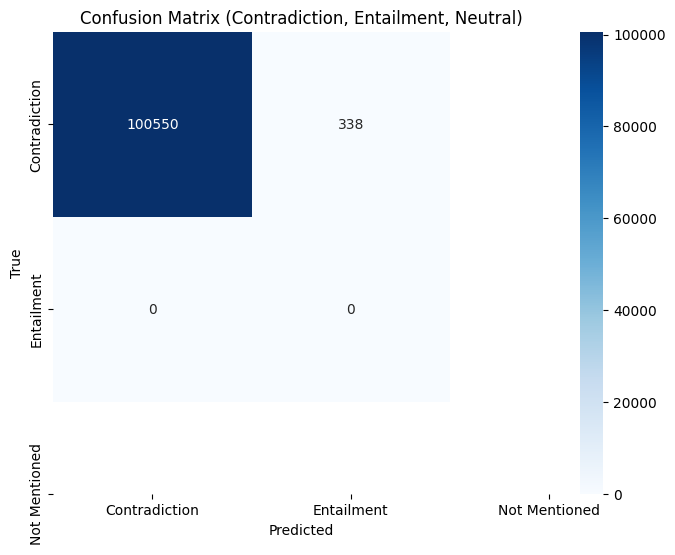

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the list of lists for Y_pred_test and Y_true_test into single arrays
all_y_pred_test = np.concatenate(Y_pred_test)
all_y_true_test = np.concatenate(Y_true_test)

# Assuming the label mapping is: 0 = Not Mentioned, 1 = Entailment, 2 = Contradiction
# Generate the confusion matrix for 3 classes
conf_matrix = confusion_matrix(all_y_true_test, all_y_pred_test)

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Contradiction', 'Entailment', 'Not Mentioned'], yticklabels=['Contradiction', 'Entailment', 'Not Mentioned'])
plt.title('Confusion Matrix (Contradiction, Entailment, Neutral)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [36]:
from sklearn.metrics import classification_report

# Flattening the list of lists for Y_pred_test and Y_true_test into single arrays
all_y_pred_test = np.concatenate(Y_pred_test)
all_y_true_test = np.concatenate(Y_true_test)

# Specify the class labels: 0 = Not Mentioned, 1 = Entailment, 2 = Contradiction
labels = [0, 1, 2]  # Assuming these are your label encodings

# Generate the classification report, ensuring all labels are considered
target_names = ['Not Mentioned', 'Entailment', 'Contradiction']
report = classification_report(all_y_true_test, all_y_pred_test, labels=labels, target_names=target_names)

# Print the classification report
print(report)


               precision    recall  f1-score   support

Not Mentioned       1.00      1.00      1.00    100888
   Entailment       0.00      0.00      0.00         0
Contradiction       0.00      0.00      0.00         0

    micro avg       1.00      1.00      1.00    100888
    macro avg       0.33      0.33      0.33    100888
 weighted avg       1.00      1.00      1.00    100888



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.